# CMPT 310: Project

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("no issue")

no issue


### Data Preprocessing

bcea_GDMPBC.csv

In [16]:
df_GDMPBC = pd.read_csv('Data/bcea_GDMPBC.csv', header=None)
df_GDMPBC = df_GDMPBC.transpose()

df_GDMPBC.columns = ['YEAR', 'GDMPBC']

print(df_GDMPBC.head())
df_GDMPBC.to_csv('Data/edited data/bcea_GDMPBC_RW.csv', index=False)

   YEAR  GDMPBC
0  1981  40,546
1  1982  37,291
2  1983  37,164
3  1984  36,997
4  1985  39,233


Unemployment.csv

In [17]:
df_Unemployment = pd.read_csv('Data/Unemployment.csv', header=None)
df_Unemployment = df_Unemployment.transpose()

df_Unemployment.columns = df_Unemployment.iloc[0]
df_Unemployment = df_Unemployment[1:]
df_Unemployment.rename(columns={'Educational attainment 7': 'YEAR'}, inplace=True)

print(df_Unemployment.iloc[0])
df_Unemployment.to_csv('Data/edited data/Unemployment_RW.csv', index=False)

0
YEAR                                       1990.0
Total, all education levels                   7.4
0 to 8  years 8                              10.5
Some high school 9                           12.9
High school graduate 10                       6.7
Some postsecondary 11                         8.8
Postsecondary certificate or diploma 12       6.2
University degree 13                          4.3
Bachelor's degree                             4.6
Above bachelor's degree                       3.9
Name: 1, dtype: object


CPI.csv

In [18]:
df_CPI = pd.read_csv('Data/CPI.csv')

df_CPI.rename(columns={'Year': 'YEAR'}, inplace=True)

print(df_CPI.head())
df_CPI.to_csv('Data/edited data/CPI_RW.csv', index=False)

   YEAR  All Items Index  Annual Percent Change
0  1980             45.4                    9.4
1  1981             51.8                   14.1
2  1982             57.3                   10.6
3  1983             60.4                    5.4
4  1984             62.8                    4.0


Housing.csv

In [19]:
df_Housing = pd.read_csv('Data/Housing.csv').drop(columns=['HISTORICAL AVERAGE PAYMENT TO INCOME PERCENT'])

print(df_Housing.iloc[0])
df_Housing.to_csv('Data/edited data/Housing_RW.csv', index=False)

YEAR                                         1979
QUARTER                                         1
HOUSING TYPE                      Single-detached
MEDIAN HOUSING PRICE                      56000.0
MEDIAN AFTER TAX FAMILY INCOME        21211.09838
PRIME INTEREST RATE                     11.961538
QUARTERLY PAYMENT                     1638.624101
PAYMENT TO INCOME PERCENT               30.901259
NUMBER OF RESALES                            2598
Name: 0, dtype: object


### Merge Dataframes

In [20]:
# remove the decimal point
df_Unemployment["YEAR"] = df_Unemployment["YEAR"].astype(int)
df_GDMPBC["YEAR"] = df_GDMPBC["YEAR"].astype(int)
df_CPI["YEAR"] = df_CPI["YEAR"].astype(int)

# groupby year
df_merged = (
    df_GDMPBC
    .merge(df_Unemployment, on='YEAR')
    .merge(df_CPI, on='YEAR')
    .merge(df_Housing, on='YEAR')
)

# remove commas and replace 'x' with NaN
df_merged = df_merged.map(lambda x: x.replace(",", "") if isinstance(x, str) else x)
df_merged = df_merged.map(lambda a: np.nan if a == "x" else a)

# convert categorical data to numerical data & set all data to float
housing_type = {"Single-detached":0, "Apartment":1, "Row housing":2, "All housing types":3}
df_merged["HOUSING TYPE"] = df_merged["HOUSING TYPE"].map(housing_type)

# for simplicity, just keep one housing type (all housing types)
df_merged = df_merged[df_merged['HOUSING TYPE'] == 3]
df_merged = df_merged.drop(columns=['HOUSING TYPE'])
df_merged = df_merged.dropna()

df_merged = df_merged.astype(float)

print(df_merged.iloc[0])
df_merged.to_csv('Data/edited data/merged_data.csv', index=False)

YEAR                                         1990.000000
GDMPBC                                      41964.000000
Total, all education levels                     7.400000
0 to 8  years 8                                10.500000
Some high school 9                             12.900000
High school graduate 10                         6.700000
Some postsecondary 11                           8.800000
Postsecondary certificate or diploma 12         6.200000
University degree 13                            4.300000
Bachelor's degree                               4.600000
Above bachelor's degree                         3.900000
All Items Index                                78.400000
Annual Percent Change                           5.400000
QUARTER                                         1.000000
MEDIAN HOUSING PRICE                       147500.000000
MEDIAN AFTER TAX FAMILY INCOME              37138.510090
PRIME INTEREST RATE                            13.846154
QUARTERLY PAYMENT              

### Simple Linear Regression (BASELINE)

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# lets try to predict housing price for years > 2018
df_train = df_merged[df_merged['YEAR'] <= 2018]
df_test = df_merged[df_merged['YEAR'] > 2018]

LR_model = LinearRegression()
LR_model.fit(df_train.drop(columns=['MEDIAN HOUSING PRICE']), df_train['MEDIAN HOUSING PRICE'])

y_pred = LR_model.predict(df_test.drop(columns=['MEDIAN HOUSING PRICE']))

mse = mean_squared_error(df_test['MEDIAN HOUSING PRICE'], y_pred)
r2 = r2_score(df_test['MEDIAN HOUSING PRICE'], y_pred)
print(f'Mean Squared Error: {mse:.2f}, Sqrt MSE: {np.sqrt(mse):.2f}')
print(f'R^2 Score: {r2:.2f}')

Mean Squared Error: 1450427135.80, Sqrt MSE: 38084.47
R^2 Score: 0.78


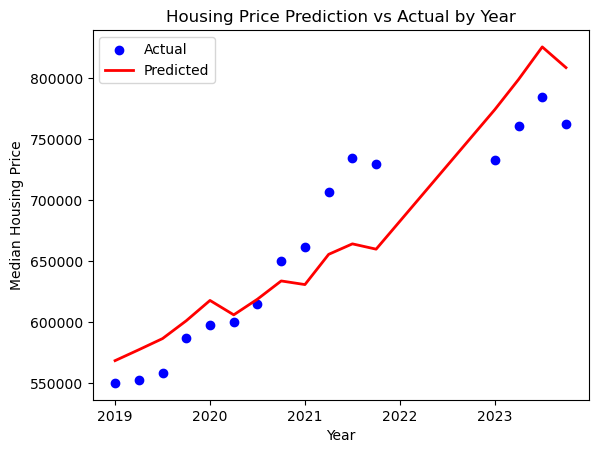

In [22]:
# merge year and quarter into a single feature for plot
df_test.loc[:, 'YEAR'] = df_test['YEAR'] + (df_test['QUARTER'] - 1) * 0.25
df_test = df_test.drop(columns=['QUARTER'])

# plot for actual values & predicted values
plt.scatter(df_test['YEAR'], df_test['MEDIAN HOUSING PRICE'], color='blue', label='Actual')
plt.plot(df_test['YEAR'], y_pred, color='red', linewidth=2, label='Predicted')

plt.xlabel('Year')
plt.ylabel('Median Housing Price')
plt.title('Housing Price Prediction vs Actual by Year')
plt.legend()
plt.show()